In [1]:
%load_ext autoreload 
%autoreload 2
import os
import pickle
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

from scipy import sparse
from scipy.sparse import coo_matrix
from scipy.sparse import save_npz

import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score, roc_auc_score

from mimic_helper_fs import get_ids_with_icd_codes, get_ids_with_kws
from mimic_helper_fs import get_coocurring_symptoms_codes, get_coocurring_symptoms_kws
from mimic_helper_fs import get_icd_code_long_title

from ipv_codes import SUSPICIOUS_SYMPTOMS_ICD_CODES

from mimic_paths import ed_path, hosp_path, admissions_path, patients_path
from mimic_paths import ed_diagnoses_path, hosp_diagnoses_path, english_names_path

pd.set_option('max_rows', 500)
pd.set_option('display.width', 500)
pd.set_option('display.max_colwidth', 80)

In [2]:
english_names = pd.read_csv(english_names_path)
diagnoses = pd.read_csv(hosp_diagnoses_path)
ed_diagnoses = pd.read_csv(ed_diagnoses_path)

# Filter out appropriate patients.

This depends upon the disease. For IPV, it makes sense to filter out men and children. 

In [4]:
admissions = pd.read_csv(admissions_path)
patients = pd.read_csv(patients_path)
sid_gender_map = dict(zip(patients.subject_id, patients.gender))
sid_age_map = dict(zip(patients.subject_id, patients.anchor_age))
sid_ethnicity_map = dict(zip(admissions.subject_id, admissions.ethnicity))
hadm_id_to_subject_id = dict(zip(diagnoses.hadm_id, diagnoses.subject_id))

In [5]:
admissions.keys()
set(admissions['marital_status'])

{'DIVORCED', 'MARRIED', 'SINGLE', 'WIDOWED', nan}

In [6]:
ed_admitted_patients = list(admissions[admissions['admission_location'] == 'EMERGENCY ROOM']['hadm_id'])

In [7]:
diagnoses['anchor_age'] = diagnoses['subject_id'].map(sid_age_map)
diagnoses['gender'] = diagnoses['subject_id'].map(sid_gender_map)
diagnoses['ethnicity'] = diagnoses['subject_id'].map(sid_ethnicity_map)

In [8]:
diagnoses = diagnoses[diagnoses['gender'] == 'F']
diagnoses = diagnoses[diagnoses['anchor_age'] > 18]
diagnoses = diagnoses[diagnoses['hadm_id'].isin(ed_admitted_patients)]

all_hadm_ids = sorted(list(set(diagnoses['hadm_id'])))
all_subject_ids = [hadm_id_to_subject_id[hadm_id] for hadm_id in all_hadm_ids]
all_icd_codes = sorted(list(set(diagnoses['icd_code'])))

code_to_index = {c: i for i,c in enumerate(all_icd_codes)}
hadm_id_to_index = {hadm_id: i for i, hadm_id in enumerate(all_hadm_ids)}

print("# of Patients: ", len(set(diagnoses['subject_id'])))
print("# of Individual Stays: ", len(set(diagnoses['hadm_id'])))
print("# of Unique ICD Codes: ", len(all_icd_codes))

# We treat each stay as a different patient, since our analysis is not longitudinal.

# of Patients:  62712
# of Individual Stays:  124239
# of Unique ICD Codes:  15699


In [9]:
ed_admits = admissions[admissions['admission_location'] == 'EMERGENCY ROOM']
ed_admits = ed_admits[ed_admits['hadm_id'].isin(diagnoses['hadm_id'])]
len(ed_admits[ed_admits['insurance'].isin(['Medicaid', 'Medicare'])]['hadm_id']), len(ed_admits)

(64167, 124239)

In [10]:
np.max(list(hadm_id_to_index.values())), len(list(hadm_id_to_index.values()))

(124238, 124239)

# Identify relevant codes

In [13]:
from mimic_helper_fs import get_icd_codes_with_prefix
from ipv_codes import GOLD_STANDARD_IPV_CODES_4, GOLD_STANDARD_IPV_CODES_1
from ipv_codes import GOLD_STANDARD_IPV_CODES_2, GOLD_STANDARD_IPV_CODES_3, Y_CODES

disease_prefix = 'ipv'

code_prefixes = GOLD_STANDARD_IPV_CODES_4 + Y_CODES
positive_codes = []
for code in code_prefixes:
    
    codes = get_icd_codes_with_prefix(english_names, code)
    positive_codes.extend(codes)
print(len(positive_codes), len(code_prefixes))

25 18


In [14]:
positive_codes

['E9672',
 'E9673',
 'E9671',
 'E9670',
 'E9679',
 'V6111',
 '99581',
 '99585',
 'T7411XA',
 'T7411XD',
 'T7411XS',
 '99580',
 'T7611',
 'T7611XA',
 'T7611XD',
 'T7611XS',
 'T7611XA',
 'T7611XD',
 'T7611XS',
 'Y070',
 'Y0701',
 'Y0702',
 'Y0703',
 'Y0704',
 'Y079']

# Create one-hot encoded features

In [15]:
one_hot = pd.get_dummies(diagnoses['icd_code'], sparse=True)
hadm_one_hot = pd.concat([diagnoses['hadm_id'], one_hot], axis=1)

In [16]:
diagnoses['icd_code_idx'] = diagnoses['icd_code'].map(code_to_index)
diagnoses['hadm_id_idx'] = diagnoses['hadm_id'].map(hadm_id_to_index)

In [17]:
# Write out one-hot features in coordinate format (helpful since matrix is very sparse)
row_coords = np.array(diagnoses['hadm_id_idx'])
col_coords = np.array(diagnoses['icd_code_idx'])
vals = np.ones(len(col_coords))

n_rows = np.max(row_coords) + 1
n_cols = np.max(col_coords) + 1

# Dummy feature for intercept
intercept_row_coords = np.array(list(range(n_rows)))
intercept_col_coords = [n_cols for i in range(n_rows)]
intercept_vals = np.ones(n_rows)

# Combine features & dummy feature for intercept
row_coords = np.concatenate([row_coords, intercept_row_coords])
col_coords = np.concatenate([col_coords, intercept_col_coords])
vals = np.concatenate([vals, intercept_vals])

# Create sparse matrix
jj = coo_matrix((vals, (row_coords, col_coords)))

In [32]:
gg = [all_icd_codes[i] for i in sus_icd_code_idxs]

[]

In [18]:
# Construct ideal classifier weights
sus_icd_code_idxs = []
for c in positive_codes:
    if c in code_to_index: 
        sus_icd_code_idxs.append(code_to_index[c])
    else:
        print("Code is not in code to index: ", c)

classifier_weights = np.zeros(len(all_icd_codes) + 1)
classifier_weights[sus_icd_code_idxs] = 1
classifier_weights = np.expand_dims(classifier_weights, 1)
classifier_weights[-1] = 0
# Why are there no ICD-10 codes in here?

Code is not in code to index:  T7411XD
Code is not in code to index:  T7411XS
Code is not in code to index:  T7611
Code is not in code to index:  T7611XD
Code is not in code to index:  T7611XS
Code is not in code to index:  T7611XD
Code is not in code to index:  T7611XS
Code is not in code to index:  Y070
Code is not in code to index:  Y0702
Code is not in code to index:  Y0704


In [19]:
# Count number of suspicious patients 
kk = jj.dot(classifier_weights)
min_symptoms_val = np.min(kk)
max_symptoms_val = np.max(kk)
r = (kk > min_symptoms_val).astype(int)
print("Range of # of symptoms: ", max_symptoms_val, min_symptoms_val)
print("# Positive: ", len(np.where(kk > min_symptoms_val)[0]))
print("# Patients with 0 Indicative Symptoms: ", len(np.where(kk == min_symptoms_val)[0]))
print("# Patients with 1 Indicative Symptoms: ", len(np.where(kk == min_symptoms_val +1)[0]))
print("# Patients with 2 Indicative Symptoms: ", len(np.where(kk == min_symptoms_val +2)[0]))
print("# Patients with 3 Indicative Symptoms: ", len(np.where(kk == min_symptoms_val +3)[0]))

print("# Total: ", len(kk))

Range of # of symptoms:  3.0 0.0
# Positive:  235
# Patients with 0 Indicative Symptoms:  124004
# Patients with 1 Indicative Symptoms:  151
# Patients with 2 Indicative Symptoms:  83
# Patients with 3 Indicative Symptoms:  1
# Total:  124239


In [20]:
# Remove columns corresponding to suspicious symtpoms that we used to construct the labels
all_idxs = list(range(jj.shape[1]))
keep_idxs = list(set(all_idxs).difference(sus_icd_code_idxs))

jj_features = sparse.lil_matrix(sparse.csr_matrix(jj)[:,np.array(keep_idxs)])
len(sus_icd_code_idxs)
feature_icd_codes = []
for i in range(len(all_icd_codes)):
    if i not in sus_icd_code_idxs:
        feature_icd_codes.append(all_icd_codes[i])
code_to_feature_index = {c: i for i,c in enumerate(all_icd_codes)}

# Redo the code to index dictionary so that the  indices still correspond to something with a name
jj_features.shape, len(feature_icd_codes)

((124239, 15686), 15685)

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(jj_features,  r, test_size=.2, stratify=r)

lr = LogisticRegression()
lr.fit(x_train, y_train)

sorted_idxs = np.argsort(-1*lr.coef_)

/data/ddmg/prism/.conda/envs/ipv_nfs/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [22]:
from mimic_helper_fs import get_icd_code_long_title
coefs = lr.coef_[0]
sorted_idxs = np.argsort(-1*lr.coef_).flatten()
for i, idx in enumerate(sorted_idxs):
    icd_code = feature_icd_codes[idx]
    descr = get_icd_code_long_title(english_names, icd_code)
    print("Rank ", i, " Coef: ", coefs[idx], "\t Code: ", icd_code, "\t ")
    print(descr)
    print()
    if i > 10:
        break

Rank  0  Coef:  4.417517215430306 	 Code:  99582 	 
Adult emotional/psychological abuse

Rank  1  Coef:  3.328024392569806 	 Code:  E9600 	 
Unarmed fight or brawl

Rank  2  Coef:  2.7677426015500317 	 Code:  E9689 	 
Assault by unspecified means

Rank  3  Coef:  2.4901351516959003 	 Code:  9599 	 
Unspecified site injury

Rank  4  Coef:  2.2007515209446407 	 Code:  920 	 
Contusion of face, scalp, and neck except eye(s)

Rank  5  Coef:  2.0637877603594887 	 Code:  99583 	 
Adult sexual abuse

Rank  6  Coef:  2.056192317787173 	 Code:  64893 	 
Other current conditions classifiable elsewhere of mother, antepartum condition or complication

Rank  7  Coef:  2.020323643111339 	 Code:  95901 	 
Head injury, unspecified

Rank  8  Coef:  1.978615282083091 	 Code:  2930 	 
Delirium due to conditions classified elsewhere

Rank  9  Coef:  1.971024147888803 	 Code:  E9674 	 
Perpetrator of child and adult abuse, by child

Rank  10  Coef:  1.811524600137434 	 Code:  E8493 	 
Accidents occurring i

In [23]:
coefs = lr.coef_[0]
sorted_idxs = np.argsort(lr.coef_).flatten()
for i, idx in enumerate(sorted_idxs):
    icd_code = feature_icd_codes[idx]
    descr = get_icd_code_long_title(english_names, icd_code)
    print("Rank ", i, " Coef: ", coefs[idx], "\t Code: ", icd_code, "\t ")
    print(descr)
    print()
    if i > 10:
        break

Rank  0  Coef:  -1.5425042290057767 	 Code:  E8809 	 
Accidental fall on or from other stairs or steps

Rank  1  Coef:  -1.3232158651465828 	 Code:  71946 	 
Pain in joint, lower leg

Rank  2  Coef:  -1.3157075815543386 	 Code:  E8889 	 
Unspecified fall

Rank  3  Coef:  -1.2228093251216217 	 Code:  V1582 	 
Personal history of tobacco use

Rank  4  Coef:  -1.145687618906468 	 Code:  E8859 	 
Fall from other slipping, tripping, or stumbling

Rank  5  Coef:  -1.1062134651898217 	 Code:  V103 	 
Personal history of malignant neoplasm of breast

Rank  6  Coef:  -1.066999419543994 	 Code:  42731 	 
Atrial fibrillation

Rank  7  Coef:  -1.0585942016427623 	 Code:  5990 	 
Urinary tract infection, site not specified

Rank  8  Coef:  -1.0456582386303122 	 Code:  78650 	 
Chest pain, unspecified

Rank  9  Coef:  -1.0082183860762446 	 Code:  27800 	 
Obesity, unspecified

Rank  10  Coef:  -1.0073281982350952 	 Code:  E956 	 
Suicide and self-inflicted injury by cutting and piercing instrument



0.0769885419790676

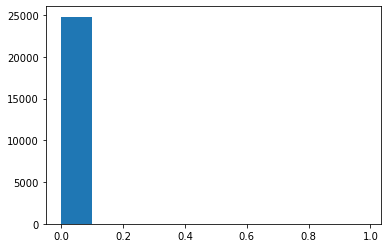

In [24]:

plt.hist(lr.predict_proba(x_test)[:,1])
y_pred = lr.predict_proba(x_test)[:,1]
average_precision_score( y_test, y_pred) # AUC of about .90

In [25]:
len(np.where(y_pred > .02)[0]), np.sum(y_test)

(168, 47)

In [26]:
# For real data, there are no splits for differently generated y, so 
# all data is saved under Split 0 
data_dir = "../data/real_true_labels/hospital/" + disease_prefix + '/'
split_num = 0
y = r
split_dir = data_dir + str(split_num) + '/'
if not os.path.exists(split_dir):
    os.makedirs(split_dir)
jj_features = sparse.coo_matrix(jj_features)
np.savetxt(split_dir + 'feat_names', feature_icd_codes, fmt="%s")
np.savetxt(split_dir + 'row_names', all_hadm_ids)
np.savetxt(split_dir + 'subject_ids', all_subject_ids)
np.savetxt(split_dir + 'observed_labels', y)
np.savetxt(split_dir + 'true_clf_weights', classifier_weights)
save_npz(split_dir + 'vals.npz', jj_features)